In [1]:
import csv
import cv2
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
lines = []
folder = 'udacity_data' 
with open(folder+'/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
print("--- CSV data loaded. ---")

# Split the dataset into training samples and validation samples (80/20 split)
train_samples, validation_samples = train_test_split(lines, test_size=0.2)
print("Train Samples: {} \nValidation Samples: {}".format(len(train_samples), len(validation_samples)))

--- CSV data loaded. ---
Train Samples: 6428 
Validation Samples: 1608


In [4]:
def brighten(img):
    try:
        img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
        rand = 0.25 + np.random.uniform()
        img[:,:,2] = img[:,:,2]*rand
        img = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
    except:
        pass
    return img

In [5]:
def flip(img, angle):
    try:
        img = (cv2.flip(img,1))
        angle = angle * -1.0
    except:
        pass
    return img, angle

In [6]:
def randomly_augment(row):
    # get the angle from the CSV
    angle = float(row[3])
    # randomly choose which camera image to use
    camera = np.random.choice(['center', 'left', 'right'])
    
    # Apply steering angle correction based on which image is chosen
    if camera == 'left':
        angle += 0.25
        camera = 1
    elif camera == 'right':
        angle -= 0.25
        camera = 2
    else:
        camera = 0
        
    # Load image from camera
    name = '/home/carnd/P3-Behavioral-Cloning/'+folder+'/IMG/'+row[camera].split('/')[-1]
    Image = cv2.imread(name)
    
    # Flip 50% of images
    flip_prob = np.random.random()
    if flip_prob >= 0.5:
        try:
            Image, angle = flip(Image, angle)
        except:
            print("--- Error flipping img in rand augment ---")
        
    # Apply a random brightness to the image
    Image = brighten(Image)
    return Image, angle
    

In [7]:
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            
            images = []
            angles = []
            for batch_sample in batch_samples:
                # Generate and randomly augment an image from the current batch sample
                Image, steering_angle = randomly_augment(batch_sample)

                try: 
                    # I was having issues when attempting to flip some images. The images were not being read in
                        # properly and so they were coming up as None. To alleviate this issue I threw in a 
                        # try / except to be able to move forward and continue with the model testing.
                        # In retrospect - I believe the issue was that I was 
                    noneTest = cv2.flip(Image,1)
                    images.append(Image)
                    angles.append(steering_angle)
                    
                except:
                    print("Exception importing data in generator fcn. \nLoading from last successfully loaded img")

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [8]:
# Init generator objects
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

Using TensorFlow backend.
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="relu", strides=(2, 2))`
  app.launch_new_instance()
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", strides=(2, 2))`
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", strides=(2, 2))`
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` cal

Epoch 1/4
480/480 [==============================] - 84s - loss: 0.0313 - val_loss: 0.0278
Epoch 2/4
480/480 [==============================] - 82s - loss: 0.0246 - val_loss: 0.0212
Epoch 3/4
480/480 [==============================] - 82s - loss: 0.0217 - val_loss: 0.0208
Epoch 4/4
480/480 [==============================] - 83s - loss: 0.0212 - val_loss: 0.0206
dict_keys(['loss', 'val_loss'])


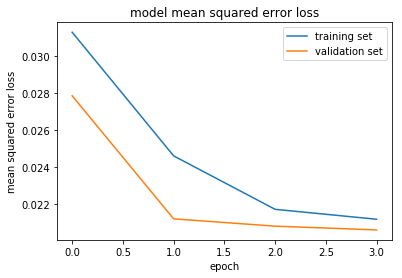

In [9]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.layers import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.models import Model

model = Sequential()

# Added normalization and cropping to help the model have an easier time training 
# (cropped out extranneous img data)
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((50,30), (0,0))))


# NVIDIA ARCHITECTURE
model.add(Convolution2D(24,5,5, subsample=(2,2),activation='relu'))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation='relu'))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation='relu'))
model.add(Convolution2D(64,3,3,activation='relu'))
model.add(Convolution2D(64,3,3,activation='relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
# model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=5)
history_object = model.fit_generator(train_generator, samples_per_epoch=480, validation_data=validation_generator, nb_val_samples=480, nb_epoch=4, verbose=1)

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

model.save('model.h5')
# import gc
# gc.collect()